# Convolutional Autoencoder

Sticking with mechanical predictions, let's improve our autoencoder's performance using convolutional layers. We'll build a convolutional autoencoder to compress the dataset.

>The encoder portion will be made of convolutional layers and the decoder will be made of **transpose convolutional layers** that learn to "upsample" a compressed representation.


### Compressed Representation

A compressed representation can be great to learn a latent space. In practice, the compressed representation often holds key information about an input image and we can use it for denoising images or model ordre reduction!

Let's get started by importing our libraries and getting the dataset.

In [1]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')
import os

Mounted at /content/drive


**Before you continue**, create a folder called Data_2025 on Google Drive and adapt the path variable below.

In [2]:
#adapt the path to Data_2025
path = "/content/drive/My Drive/PSL_intensive_week/Data_2025"
os.chdir(path)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# download data from zenodo.org
#!wget http://zenodo.org/records/14886685/files/All_dof_fluctuations.npy

In [4]:
def my_normalization_parameters(train_data):
  mean_train = train_data.mean(axis=0)
  std_train = train_data.std(axis=0)
  return mean_train, std_train
def get_normalized_data(data, mean_train, std_train):
  return (data - mean_train)/std_train

In [5]:
image_o = np.load('All_dof_fluctuations.npy').reshape(4000,48,48,6)
image_2D = np.vstack((image_o[:,:,:,0],image_o[:,:,:,1],image_o[:,:,:,2],image_o[:,:,:,3],image_o[:,:,:,4],image_o[:,:,:,5]))
image_2D = np.expand_dims(image_2D, axis = 1)
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(image_2D,test_size=0.2)
train_data, validation_data = train_test_split(train_data,test_size=0.2)
del image_2D
mean_train, std_train = my_normalization_parameters(train_data)
train_data = get_normalized_data(train_data, mean_train, std_train)
validation_data = get_normalized_data(validation_data, mean_train, std_train)
test_data = get_normalized_data(test_data, mean_train, std_train)

In [ ]:
import torch
train_data = torch.from_numpy(train_data).float()
validation_data = torch.from_numpy(validation_data).float()
test_data = torch.from_numpy(test_data).float()

### Data loader for PyTorch

In [ ]:
num_workers = 0
# how many samples per batch to load
batch_size = 40

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
val_loader = torch.utils.data.DataLoader(validation_data, batch_size= batch_size*2 , num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

### Visualize the Data



In [6]:
48*48*1

2304

Image shape:  torch.Size([40, 1, 48, 48])


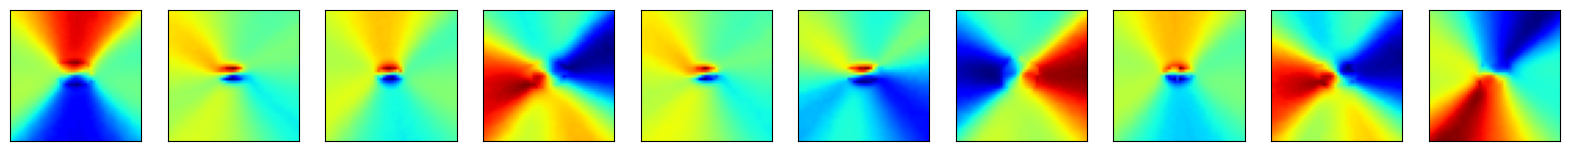

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# obtain one batch of training images
dataiter = iter(train_loader)
for images in dataiter:
    break

print('Image shape: ', images.shape)

# get one image from the batch
images = images.numpy()

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
# get one image from the batch
    img = np.squeeze(images[i])
    plt.imshow(img,cmap='jet')
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

---
## Convolutional  Autoencoder

#### Encoder
The encoder part of the network will be a typical convolutional pyramid.

#### Decoder

The decoder though might be something new to you. The decoder needs to convert from a narrow representation to a wide, reconstructed image.

### Transpose Convolutions, Decoder

This decoder uses **transposed convolutional** layers to increase the width and height of the input layers. They work almost exactly the same as convolutional layers, but in reverse. A stride in the input layer results in a larger stride in the transposed convolution layer. For example, if you have a 3x3 kernel, a 3x3 patch in the input layer will be reduced to one unit in a convolutional layer. Comparatively, one unit in the input layer will be expanded to a 3x3 path in a transposed convolution layer. PyTorch provides us with an easy way to create the layers, [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/nn.html#convtranspose2d).

It is important to note that transpose convolution layers can lead to artifacts in the final images, such as checkerboard patterns. This is due to overlap in the kernels which can be avoided by setting the stride and kernel size equal. In [this Distill article](http://distill.pub/2016/deconv-checkerboard/) from Augustus Odena, *et al*, the authors show that these checkerboard artifacts can be avoided by resizing the layers using nearest neighbor or bilinear interpolation (upsampling) followed by a convolutional layer.

> We'll show this approach in another notebook, so you can experiment with it and see the difference.


#### TODO: Build the network shown above.
> Run the Notebook
> Change de dimension of the latent space and discuss the results.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# define the NN architecture
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        ## encoder layers ##
        # conv layer (channels from 1 --> 16), 3x3 filters
        self.conv1 = nn.Conv2d(1, 16, 3, stride = 1, padding=1)
        # conv layer (channels from 16 --> 4), 3x3 filters
        self.conv2 = nn.Conv2d(16, 4, 3, stride = 2, padding=1)
        # flatten
        self.flatten = nn.Flatten()
        # Latent space
        self.fc1 = nn.Linear(2304, 128)
        self.fc3 = nn.Linear(128,2304)

        ## decoder layers ##
        self.fc4 = nn.Unflatten(1,torch.Size([4,24,24]))
        ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(4, 16, 2, stride=2, padding = 1, output_padding=0)
        self.t_conv2 = nn.Conv2d(16, 8, 2, stride=1, padding = 1)
        self.t_conv3 = nn.Conv2d(8, 1, 2, stride=1, padding = 1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with tanh activation function
        x = F.gelu(self.conv1(x))
        x = F.gelu(self.conv2(x))
        x = self.flatten(x)
        x = F.gelu(self.fc1(x)) # latent variables z=x
        ## decode ##
        x = F.gelu(self.fc3(x))
        x = self.fc4(x)
        ## add transpose conv layers, with tanh activation function
        x = F.gelu(self.t_conv1(x))
        x = F.gelu(self.t_conv2(x))
        # output layer
        x = self.t_conv3(x)
        return x

    def encoder(self, x):
        ## encode
        x = F.gelu(self.conv1(x))
        x = F.gelu(self.conv2(x))
        x = self.flatten(x)
        x = F.gelu(self.fc1(x)) # latent variables
        return x

    def decoder(self,x):
        ## decode the latent variable x
        x = F.gelu(self.fc3(x))
        x = self.fc4(x)
        ## add transpose conv layers, with tanh activation function
        x = F.gelu(self.t_conv1(x))
        x = F.gelu(self.t_conv2(x))
        # output layer
        x = self.t_conv3(x)
        return x

# initialize the NN
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 4, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=2304, bias=True)
  (fc4): Unflatten(dim=1, unflattened_size=torch.Size([4, 24, 24]))
  (t_conv1): ConvTranspose2d(4, 16, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
  (t_conv2): Conv2d(16, 8, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (t_conv3): Conv2d(8, 1, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
)


---
## Training

Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss and the test loss afterwards.

We are not concerned with labels in this case, just images, which we can get from the `train_loader`. Because we're comparing pixel values in input and output images, it will be best to use a loss that is meant for a regression task. Regression is all about comparing quantities rather than probabilistic values. So, in this case, I'll use `MSELoss`. And compare output images and input images as follows:
```
loss = criterion(outputs, images)
```

Otherwise, this is pretty straightfoward training with PyTorch. Since this is a convlutional autoencoder, our images _do not_ need to be flattened before being passed in an input to our model.

In [ ]:
# specify loss function
criterion = nn.MSELoss()

# specify loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=0.7, end_factor=0.8)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)

In [ ]:
## load model weigths for transfer learning
#weigths_pretrained = torch.load('best_model_Gelu.pth',weights_only=True)
#model.load_state_dict(weigths_pretrained)

In [ ]:
# number of epochs to train the model
n_epochs = 50

best_metric = float('inf')  # For loss, you might want to minimize it
best_model_wts = None
train_loss_history = []
val_loss_history = []

for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0

    ###################
    # train the model #
    ###################
    for data in train_loader:
        images = data
        ## forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        optimizer.zero_grad()
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)

    scheduler.step()
    # print avg training statistics
    train_loss = train_loss/len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            val_loss += loss.item() * inputs.size(0)

    val_loss = val_loss / len(val_loader)
    print('Epoch: {} \tTraining Loss: {:.3e} \tValidation Loss {:.3e}'.format(
        epoch,
        train_loss,
        val_loss,
        ))

    # Check if this is the best model
    if val_loss < best_metric:
        best_metric = val_loss
        best_model_wts = model.state_dict()

    # To plot losses
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)

# Load best model weights
model.load_state_dict(best_model_wts)

Epoch: 1 	Training Loss: 1.122e+01 	Validation Loss 3.825e+00
Epoch: 2 	Training Loss: 4.451e+00 	Validation Loss 3.208e+00
Epoch: 3 	Training Loss: 8.102e+00 	Validation Loss 3.628e+00
Epoch: 4 	Training Loss: 7.153e+00 	Validation Loss 2.052e+00
Epoch: 5 	Training Loss: 6.601e+00 	Validation Loss 2.039e+00
Epoch: 6 	Training Loss: 3.335e+00 	Validation Loss 1.759e+00
Epoch: 7 	Training Loss: 8.919e+00 	Validation Loss 1.177e+01
Epoch: 8 	Training Loss: 4.886e+00 	Validation Loss 1.782e+00
Epoch: 9 	Training Loss: 3.451e+00 	Validation Loss 1.664e+00
Epoch: 10 	Training Loss: 4.141e+00 	Validation Loss 1.412e+00
Epoch: 11 	Training Loss: 2.646e+00 	Validation Loss 1.562e+00
Epoch: 12 	Training Loss: 3.307e+00 	Validation Loss 1.038e+00
Epoch: 13 	Training Loss: 1.867e+00 	Validation Loss 1.274e+00
Epoch: 14 	Training Loss: 9.073e+00 	Validation Loss 3.785e+00
Epoch: 15 	Training Loss: 5.678e+00 	Validation Loss 1.831e+00
Epoch: 16 	Training Loss: 2.790e+00 	Validation Loss 1.458e+00
E

<All keys matched successfully>

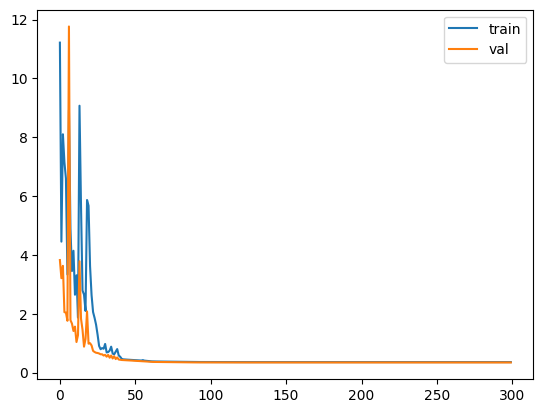

In [ ]:
plt.plot(train_loss_history)
plt.plot(val_loss_history)
plt.legend(['train','val'])
plt.show()

In [ ]:
# save the best model
torch.save(model.state_dict(), 'best_model.pth')

## Checking out the results

Below I've plotted some of the test images along with their reconstructions. These look a little rough around the edges, likely due to the checkerboard effect we mentioned above that tends to happen with transpose layers.

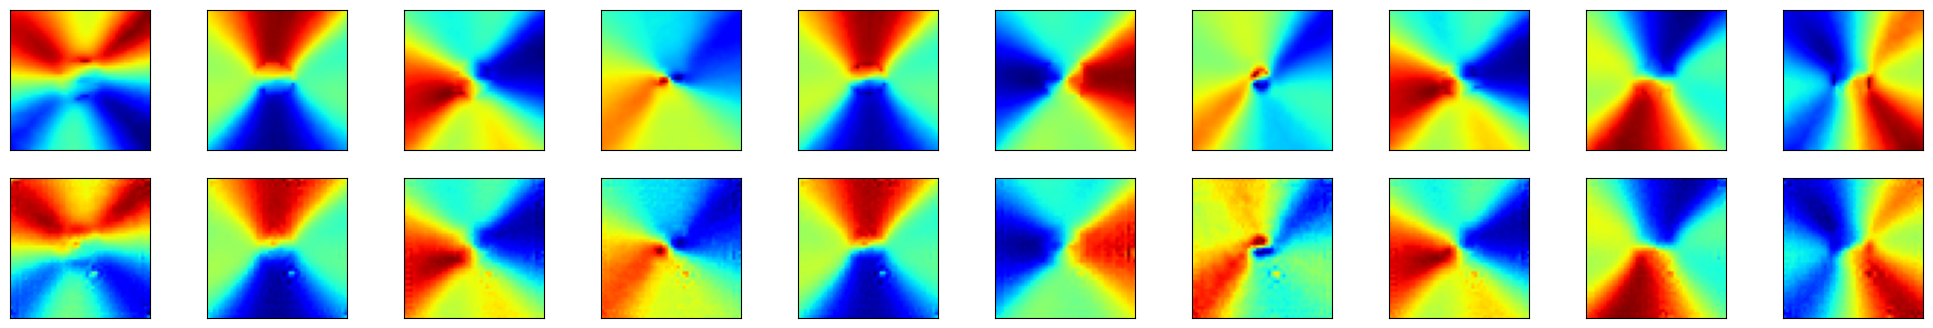

In [ ]:
# obtain one batch of test images
dataiter = iter(val_loader)
for images in dataiter:
    break

# get sample outputs
output = model(images)
# prep images for display
images = images.numpy()

# output is resized into a batch of iages
output = output.view(images.shape[0], 1, 48, 48)
# use detach when it's an output that requires_grad
output = output.detach().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='jet')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)